## 부탁 드립니다!

본 자료는 패스트캠퍼스 RAG 비법노트 강의에서 유료 강의로 제공되는 자료입니다. 

따라서, 제공된 코드를 사용하여 개발하는 것은 얼마든지 가능합니다만,

**제 3자 에게 무단배포, 웹에 소스코드 게재 및 배포는 금지**하고 있다는 점 부디 양해해 주시기 바랍니다.

개발 및 학습 목적으로만 활용해 주세요. 많은 도움이 되었으면 좋겠습니다. 늘 감사드립니다.

## 환경 설정

- [Upstage Document Parse](https://console.upstage.ai/docs/capabilities/document-parse)
- [API 키 발급](https://console.upstage.ai/api-keys)

`.env` 파일을 생성하고 키를 입력합니다.

- `UPSTAGE_API_KEY`: Upstage API 키

In [9]:
from dotenv import load_dotenv

load_dotenv()

True

In [10]:
from langchain_teddynote import logging

logging.langsmith("TeddyNote-Parser", set_enable=False)

LangSmith 추적을 하지 않습니다.


## Upstage Parser V2 모듈(업그레이드 버전)

- 자세한 설명은 2024년 11월 주주총회 영상을 꼭 시청해 주세요! (패스트캠퍼스 강의실 내 업로드)

In [3]:
# PDF 파싱을 위한 필수 라이브러리들을 임포트합니다
import os
from layoutparse.utils import (
    SplitPDFFilesNode,
)  # PDF 파일을 분할하는 노드를 임포트합니다
from layoutparse.state import ParseState  # 파싱 상태를 관리하는 클래스를 임포트합니다
from layoutparse.upstage import (  # Upstage 관련 주요 노드들을 임포트합니다
    DocumentParseNode,  # 문서 파싱을 담당하는 노드
    PostDocumentParseNode,  # 파싱 후처리를 담당하는 노드
    WorkingQueueNode,  # 작업 큐를 관리하는 노드
    continue_parse,  # 파싱 계속 여부를 결정하는 함수
)
from langgraph.graph import StateGraph  # 그래프 상태를 관리하는 클래스를 임포트합니다
from langgraph.checkpoint.memory import (
    MemorySaver,
)  # 메모리 체크포인트 저장을 위한 클래스입니다
from langchain_teddynote.graphs import (
    visualize_graph,
)  # 그래프 시각화를 위한 함수를 임포트합니다


# PDF 파일을 30페이지 단위로 분할하는 노드를 생성합니다
split_pdf_node = SplitPDFFilesNode(batch_size=30, test_page=None, verbose=True)

# Upstage API를 사용하여 문서를 파싱하는 노드를 생성합니다
document_parse_node = DocumentParseNode(
    api_key=os.environ["UPSTAGE_API_KEY"], verbose=True
)

# 파싱 후처리를 담당하는 노드를 생성합니다
post_document_parse_node = PostDocumentParseNode(verbose=True)
# 작업 큐를 관리하는 노드를 생성합니다
working_queue_node = WorkingQueueNode(verbose=True)


# ParseState를 기반으로 하는 StateGraph 워크플로우를 생성합니다
workflow = StateGraph(ParseState)

# 워크플로우에 각각의 노드들을 추가합니다
workflow.add_node("split_pdf_node", split_pdf_node)
workflow.add_node("document_parse_node", document_parse_node)
workflow.add_node("post_document_parse_node", post_document_parse_node)
workflow.add_node("working_queue_node", working_queue_node)

# 노드들 간의 연결 관계를 설정합니다
workflow.add_edge("split_pdf_node", "working_queue_node")
# 작업 큐 노드에서 조건에 따라 다음 노드를 결정하는 분기를 추가합니다
workflow.add_conditional_edges(
    "working_queue_node",
    continue_parse,
    {True: "document_parse_node", False: "post_document_parse_node"},
)
workflow.add_edge("document_parse_node", "working_queue_node")

# 워크플로우의 시작점을 PDF 분할 노드로 설정합니다
workflow.set_entry_point("split_pdf_node")

# 최종적으로 메모리 체크포인터를 사용하여 워크플로우를 컴파일합니다
document_parse_graph = workflow.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

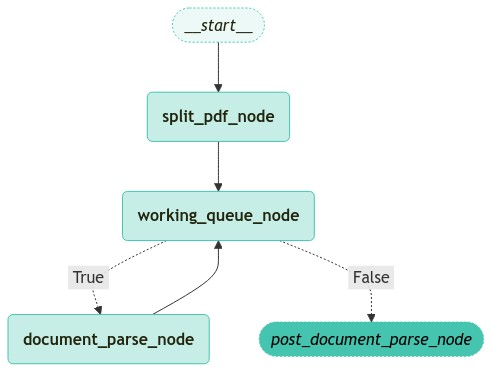

In [4]:
# 그래프를 시각화합니다
visualize_graph(document_parse_graph)

In [5]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph
import uuid

"""
RunnableConfig를 사용하여 그래프 실행에 필요한 설정을 정의합니다.
recursion_limit: 재귀 호출의 제한을 설정하여 무한 루프를 방지합니다
configurable: 실행 시 필요한 설정값들을 정의합니다
"""
config = RunnableConfig(
    recursion_limit=300,  # 재귀 호출 제한을 300으로 설정합니다
    configurable={"thread_id": str(uuid.uuid4())},
)

# ParseState 객체를 생성하여 PDF 파일 처리를 위한 초기 상태를 설정합니다
inputs = ParseState(
    filepath="data/argus-bitumen.pdf",  # 처리할 PDF 파일의 경로를 지정합니다
    language="English",  # 문서의 언어를 영어로 설정합니다
)

# 그래프를 스트리밍 모드로 실행하여 실시간으로 처리 상태를 확인합니다
stream_graph(
    document_parse_graph,
    inputs,
    config=config,
)

[SplitPDFNode] 파일의 전체 페이지 수: 21 Pages.
[SplitPDFNode] 분할 PDF 생성: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Start Parsing: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Finished Parsing in 19.49 seconds
[PostDocumentParseNode] Total Post-processed Elements: 465
[PostDocumentParseNode] Total Cost: $0.21


In [6]:
# 실행 결과
snapshot = document_parse_graph.get_state(config).values

In [7]:
# 추출된 요소들을 확인합니다
snapshot["elements_from_parser"]

[{'category': 'paragraph',
  'content': {'html': "<p id='0' data-category='paragraph' style='font-size:20px'>Europe, Africa, Middle East and Asia-Pacific prices and commentary<br>Incorporating Argus Asphalt Report</p>",
   'markdown': 'Europe, Africa, Middle East and Asia-Pacific prices and commentary\nIncorporating Argus Asphalt Report',
   'text': 'Europe, Africa, Middle East and Asia-Pacific prices and commentary\nIncorporating Argus Asphalt Report'},
  'coordinates': [{'x': 0.3217, 'y': 0.1249},
   {'x': 0.9273, 'y': 0.1249},
   {'x': 0.9273, 'y': 0.156},
   {'x': 0.3217, 'y': 0.156}],
  'id': 0,
  'page': 0},
 {'category': 'paragraph',
  'content': {'html': "<p id='1' data-category='paragraph' style='font-size:20px'>SUMMARY</p>",
   'markdown': 'SUMMARY',
   'text': 'SUMMARY'},
  'coordinates': [{'x': 0.0733, 'y': 0.2237},
   {'x': 0.1626, 'y': 0.2237},
   {'x': 0.1626, 'y': 0.2374},
   {'x': 0.0733, 'y': 0.2374}],
  'id': 1,
  'page': 0},
 {'category': 'paragraph',
  'content': {

## 쉬운 사용

### `upstage_parser_graph` 생성

- `batch_size`: 한번에 처리할 페이지 수
- `test_page`: 테스트할 페이지 번호
- `verbose`: 디버깅 메시지 출력 여부


In [8]:
from layoutparse.teddynote_parser import create_upstage_parser_graph

# 그래프 생성
upstage_parser_graph = create_upstage_parser_graph(
    batch_size=30, test_page=None, verbose=True
)

### `upstage_parser_graph` 사용

- `filepath`: 분석할 PDF 파일의 경로

In [15]:
import uuid
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph

# 옵션 설정
config = RunnableConfig(
    recursion_limit=300,
    configurable={"thread_id": str(uuid.uuid4())},
)

# filepath: 분석할 PDF 파일의 경로
inputs = {
    "filepath": "data/argus-bitumen.pdf",
}

stream_graph(upstage_parser_graph, inputs, config=config)

[SplitPDFNode] 파일의 전체 페이지 수: 21 Pages.
[SplitPDFNode] 분할 PDF 생성: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Start Parsing: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Finished Parsing in 18.62 seconds
[PostDocumentParseNode] Total Post-processed Elements: 465
[PostDocumentParseNode] Total Cost: $0.21


In [16]:
# 추출된 요소들을 확인합니다
elements = upstage_parser_graph.get_state(config).values["elements_from_parser"]
elements[-20:]

[{'category': 'paragraph',
  'content': {'html': "<br><p id='445' data-category='paragraph' style='font-size:14px'>ARGUS, the ARGUS logo, ARGUS MEDIA, INTEGER,<br>ARGUS BITUMEN , other ARGUS publication titles<br>and ARGUS index names are trademarks of Argus<br>Media Limited.<br>Visit www.argusmedia.com/Ft/trademarks for<br>more information.</p>",
   'markdown': 'ARGUS, the ARGUS logo, ARGUS MEDIA, INTEGER,\nARGUS BITUMEN , other ARGUS publication titles\nand ARGUS index names are trademarks of Argus\nMedia Limited.\nVisit www.argusmedia.com/Ft/trademarks for\nmore information.',
   'text': 'ARGUS, the ARGUS logo, ARGUS MEDIA, INTEGER,\nARGUS BITUMEN , other ARGUS publication titles\nand ARGUS index names are trademarks of Argus\nMedia Limited.\nVisit www.argusmedia.com/Ft/trademarks for\nmore information.'},
  'coordinates': [{'x': 0.35, 'y': 0.6126},
   {'x': 0.5765, 'y': 0.6126},
   {'x': 0.5765, 'y': 0.67},
   {'x': 0.35, 'y': 0.67}],
  'id': 445,
  'page': 20},
 {'category': 'para